In [1]:
import torch
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
from plantcv import plantcv as pcv
from matplotlib.patches import Patch
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchmetrics.detection import IntersectionOverUnion

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.getcwd())
folder_path

In [2]:
def get_accuracy(output, target):
    # Assuming output and target are torch tensors with values of 0 or 1
    correct_pixels = np.equal(output, target).sum().item()
    total_pixels = target.size
    accuracy = correct_pixels / total_pixels
    return accuracy

In [3]:
def get_IoU(output, target):
    output_disk = np.copy(output)
    output_cup = np.copy(output)
    target_disk = np.copy(target)
    target_cup = np.copy(target)

    output_disk[output_disk == 2] = 1
    output_cup[output_cup == 1] = 0
    output_cup[output_cup == 2] = 1

    target_disk[target_disk == 2] = 1
    target_cup[target_cup == 1] = 0
    target_cup[target_cup == 2] = 1
    
    intersection_disk = np.logical_and(output_disk, target_disk).sum().item()
    union_disk = np.logical_or(output_disk, target_disk).sum().item()
    iou_disk = intersection_disk / union_disk if union_disk != 0 else 0.0

    intersection_cup = np.logical_and(output_cup, target_cup).sum().item()
    union_cup = np.logical_or(output_cup, target_cup).sum().item()
    iou_cup = intersection_cup / union_cup if union_cup != 0 else 0.0

    avg_iou = (iou_disk + iou_cup) / 2
    return avg_iou

In [4]:
def dice_coefficient(prediction, target, smooth=1e-5, num_classes=3):
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)
    
    for class_index in range(1, num_classes):
        pred_class = prediction == class_index
        tar_class = target == class_index
        
        intersection[class_index] = np.sum(pred_class & tar_class)
        union[class_index] = np.sum(pred_class) + np.sum(tar_class)
    dice_scores = (2.0 * intersection + smooth) / (union + smooth)
    dice_scores = dice_scores[1:]
    avg_dice = np.mean(dice_scores)
    return avg_dice

In [5]:
image = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined\Test\611.jpg')
predicted_link_psp = loadmat(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined\PSPNet_LinkNet\611.mat').get('mask')
predicted_psp_only = loadmat(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined\PSPNet_only\611.mat').get('mask')
ground_truth = Image.open(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined\Test_gt\611.png')
ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
ground_truth = np.array(ground_truth)

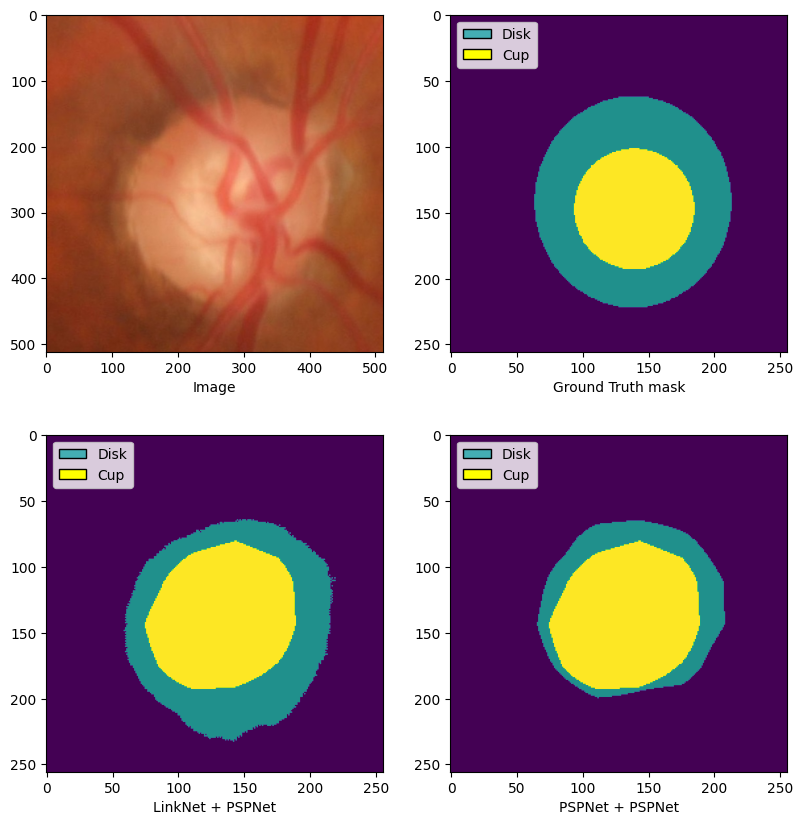

In [6]:
plt.figure(figsize=(20,20))
legend_elements = [
    Patch(facecolor='#44AEB3', edgecolor='black', label='Disk'),
    Patch(facecolor='yellow', edgecolor='black', label='Cup'),
]
plt.subplot(2,4,1)  #2,4,1
plt.imshow(image)
plt.xlabel("Image")
plt.subplot(2,4,2)   #
plt.imshow(ground_truth)
plt.xlabel("Ground Truth mask")
plt.legend(handles=legend_elements, loc='upper left')
plt.subplot(1,4,1)   #2,4,2
plt.imshow(predicted_link_psp)
plt.xlabel("LinkNet + PSPNet")
plt.legend(handles=legend_elements, loc='upper left')
plt.subplot(1,4,2)   #1,4,1
plt.imshow(predicted_psp_only)
plt.xlabel("PSPNet + PSPNet")
plt.legend(handles=legend_elements, loc='upper left')

In [7]:
psp_link_acc = get_accuracy(predicted_link_psp, ground_truth)
psp_only_acc = get_accuracy(predicted_psp_only, ground_truth)
print("Link+PSP: " + str(psp_link_acc) + "\nPSP only: "+ str(psp_only_acc))

Link+PSP: 0.9146270751953125
PSP only: 0.8862152099609375


In [8]:
psp_link_iou = get_IoU(predicted_link_psp, ground_truth)
psp_only_iou = get_IoU(predicted_psp_only, ground_truth)
print("Link+PSP: " + str(psp_link_iou) + "\nPSP only: "+ str(psp_only_iou))

Link+PSP: 0.7727079465563085
PSP only: 0.7190421990735505


In [9]:
psp_link_dice = dice_coefficient(predicted_link_psp, ground_truth)
psp_only_dice = dice_coefficient(predicted_psp_only, ground_truth)
print("Link+PSP: " + str(psp_link_dice) + "\nPSP only: "+ str(psp_only_dice))

Link+PSP: 0.7662131942075457
PSP only: 0.6750226544480546


In [10]:
unique_values, counts = np.unique(predicted_link_psp, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    45442
1:    10153
2:    9941


# Evaluation for all test data

In [11]:
images_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined\Test'
prediction_path_linkpsp = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined\PSPNet_LinkNet'
prediction_path_psppsp = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined\PSPNet_only'
ground_truth_path = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\Combined\Test_gt'

In [12]:
images_list = os.listdir(images_path)
predicted_list_linkpsp = os.listdir(prediction_path_linkpsp)
predicted_list_psppsp = os.listdir(prediction_path_psppsp)
ground_truth_list = os.listdir(ground_truth_path)

In [13]:
global_acc_test_linkpsp = 0
global_acc_test_psppsp = 0

global_acc_test_linkpsp_array = []
global_acc_test_psppsp_array = []
for prediction_linkpsp, prediction_psppsp ,gt in zip(predicted_list_linkpsp, predicted_list_psppsp, ground_truth_list):
    predicted_linkpsp = loadmat(prediction_path_linkpsp + '\/'+prediction_linkpsp).get('mask')
    predicted_psppsp = loadmat(prediction_path_psppsp + '\/'+prediction_psppsp).get('mask')
    
    # predicted_linkpsp = np.squeeze(predicted_linkpsp, axis=-1)
    # predicted_psppsp = np.squeeze(predicted_psppsp, axis=-1)
    
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    
    acc_linkpsp = get_accuracy(predicted_linkpsp, ground_truth)
    acc_psppsp = get_accuracy(predicted_psppsp, ground_truth)

    global_acc_test_linkpsp += acc_linkpsp
    global_acc_test_psppsp += acc_psppsp

    global_acc_test_linkpsp_array.append(acc_linkpsp)
    global_acc_test_psppsp_array.append(acc_psppsp)
    
global_acc_test_linkpsp = global_acc_test_linkpsp/len(images_list)
global_acc_test_psppsp = global_acc_test_psppsp/len(images_list)

print("Link+PSP: " + str(global_acc_test_linkpsp) + "\nPSP only: "+ str(global_acc_test_psppsp))

Link+PSP: 0.90548583984375
PSP only: 0.897032470703125


In [14]:
global_iou_test_linkpsp = 0
global_iou_test_psppsp = 0

global_iou_test_linkpsp_array = []
global_iou_test_psppsp_array = []
for prediction_linkpsp, prediction_psppsp ,gt in zip(predicted_list_linkpsp, predicted_list_psppsp, ground_truth_list):
    predicted_linkpsp = loadmat(prediction_path_linkpsp + '\/'+prediction_linkpsp).get('mask')
    predicted_psppsp = loadmat(prediction_path_psppsp + '\/'+prediction_psppsp).get('mask')
    
    # predicted_linkpsp = np.squeeze(predicted_linkpsp, axis=-1)
    # predicted_psppsp = np.squeeze(predicted_psppsp, axis=-1)
    
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    
    iou_linkpsp = get_IoU(predicted_linkpsp, ground_truth)
    iou_psppsp = get_IoU(predicted_psppsp, ground_truth)

    global_iou_test_linkpsp += iou_linkpsp
    global_iou_test_psppsp += iou_psppsp

    global_iou_test_linkpsp_array.append(iou_linkpsp)
    global_iou_test_psppsp_array.append(iou_psppsp)
    
global_iou_test_linkpsp = global_iou_test_linkpsp/len(images_list)
global_iou_test_psppsp = global_iou_test_psppsp/len(images_list)

print("Link+PSP: " + str(global_iou_test_linkpsp) + "\nPSP only: "+ str(global_iou_test_psppsp))

Link+PSP: 0.7902047080753899
PSP only: 0.7694789909254025


In [15]:
global_dice_test_linkpsp = 0
global_dice_test_psppsp = 0

global_dice_test_linkpsp_array = []
global_dice_test_psppsp_array = []
for prediction_linkpsp, prediction_psppsp ,gt in zip(predicted_list_linkpsp, predicted_list_psppsp, ground_truth_list):
    predicted_linkpsp = loadmat(prediction_path_linkpsp + '\/'+prediction_linkpsp).get('mask')
    predicted_psppsp = loadmat(prediction_path_psppsp + '\/'+prediction_psppsp).get('mask')
    
    # predicted_linkpsp = np.squeeze(predicted_linkpsp, axis=-1)
    # predicted_psppsp = np.squeeze(predicted_psppsp, axis=-1)
    
    ground_truth = Image.open(ground_truth_path + '\/'+gt)

    ground_truth = ground_truth.resize((256, 256), resample=Image.NEAREST)
    ground_truth = np.array(ground_truth)
    
    dice_linkpsp = dice_coefficient(predicted_linkpsp, ground_truth)
    dice_psppsp = dice_coefficient(predicted_psppsp, ground_truth)

    global_dice_test_linkpsp += dice_linkpsp
    global_dice_test_psppsp += dice_psppsp

    global_dice_test_linkpsp_array.append(dice_linkpsp)
    global_dice_test_psppsp_array.append(dice_psppsp)
    
global_dice_test_linkpsp = global_dice_test_linkpsp/len(images_list)
global_dice_test_psppsp = global_dice_test_psppsp/len(images_list)

print("Link+PSP: " + str(global_dice_test_linkpsp) + "\nPSP only: "+ str(global_dice_test_psppsp))

Link+PSP: 0.788515157119836
PSP only: 0.7473232679681517


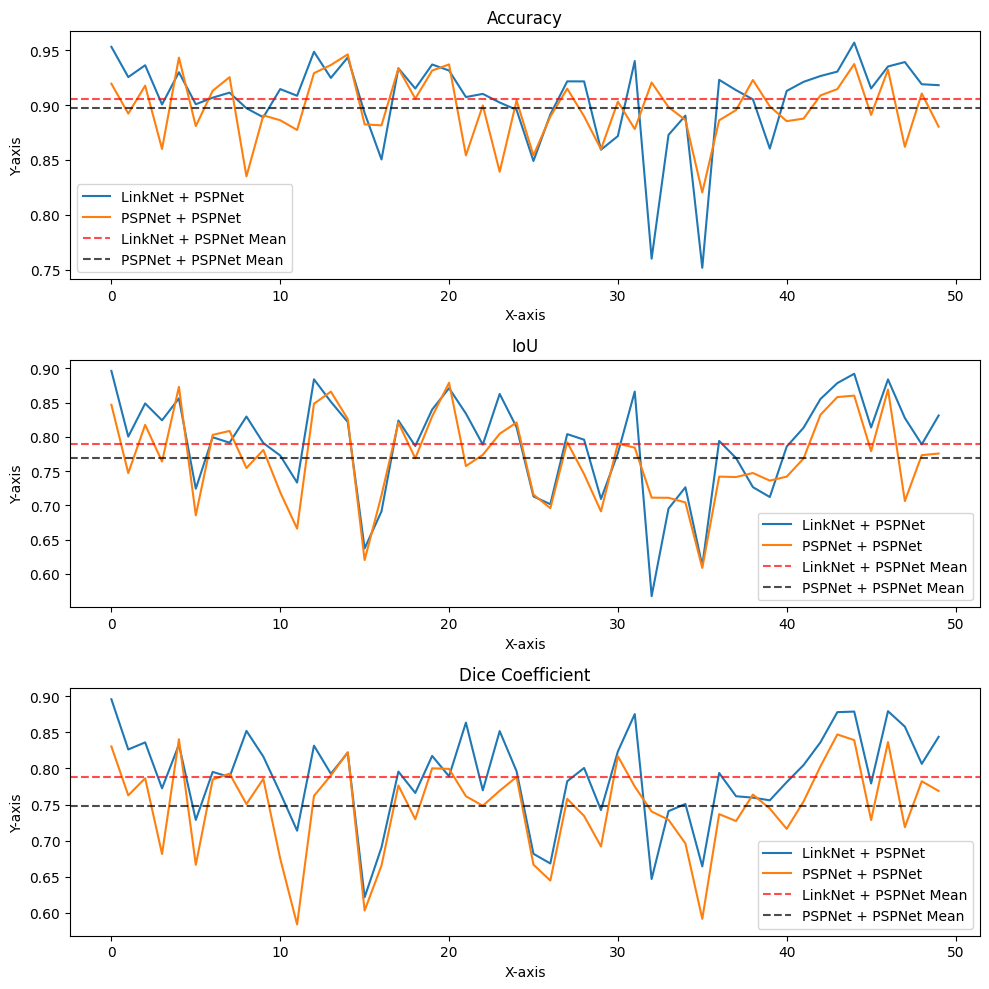

In [16]:
fig, axs = plt.subplots(3, figsize=(10, 10))

axs[0].plot(global_acc_test_linkpsp_array, label='LinkNet + PSPNet')
axs[0].plot(global_acc_test_psppsp_array, label='PSPNet + PSPNet')
axs[0].axhline(y=np.mean(global_acc_test_linkpsp_array), color='red', alpha=0.7, linestyle='--', label='LinkNet + PSPNet Mean')
axs[0].axhline(y=np.mean(global_acc_test_psppsp_array), color='black', alpha=0.7, linestyle='--', label='PSPNet + PSPNet Mean')

axs[1].plot(global_iou_test_linkpsp_array, label='LinkNet + PSPNet')
axs[1].plot(global_iou_test_psppsp_array, label='PSPNet + PSPNet')
axs[1].axhline(y=np.mean(global_iou_test_linkpsp_array), color='red', alpha=0.7, linestyle='--', label='LinkNet + PSPNet Mean')
axs[1].axhline(y=np.mean(global_iou_test_psppsp_array), color='black', alpha=0.7, linestyle='--', label='PSPNet + PSPNet Mean')

axs[2].plot(global_dice_test_linkpsp_array, label='LinkNet + PSPNet')
axs[2].plot(global_dice_test_psppsp_array, label='PSPNet + PSPNet')
axs[2].axhline(y=np.mean(global_dice_test_linkpsp_array), color='red', alpha=0.7, linestyle='--', label='LinkNet + PSPNet Mean')
axs[2].axhline(y=np.mean(global_dice_test_psppsp_array), color='black', alpha=0.7, linestyle='--', label='PSPNet + PSPNet Mean')

axs[0].legend()
axs[1].legend()
axs[2].legend()

# Add labels and title
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].set_title('Accuracy') 

axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')
axs[1].set_title('IoU') 

axs[2].set_xlabel('X-axis')
axs[2].set_ylabel('Y-axis')
axs[2].set_title('Dice Coefficient') 

plt.tight_layout()

plt.show()

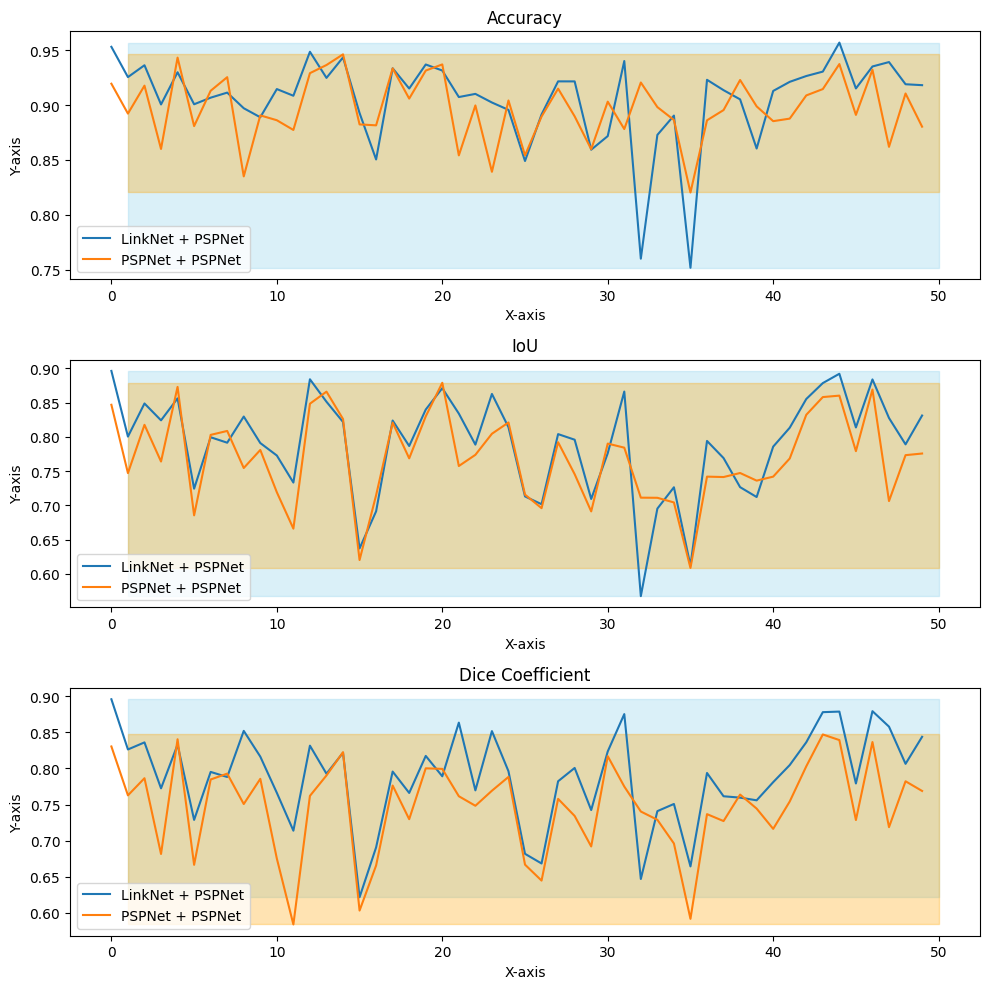

In [17]:
fig, axs = plt.subplots(3, figsize=(10, 10))

axs[0].plot(global_acc_test_linkpsp_array, label='LinkNet + PSPNet')
axs[0].plot(global_acc_test_psppsp_array, label='PSPNet + PSPNet')
axs[0].fill_between([i for i in range(1, len(global_acc_test_linkpsp_array) + 1)], np.max(global_acc_test_linkpsp_array), np.min(global_acc_test_linkpsp_array), color='skyblue', alpha=0.3)
axs[0].fill_between([i for i in range(1, len(global_acc_test_psppsp_array) + 1)], np.max(global_acc_test_psppsp_array), np.min(global_acc_test_psppsp_array), color='orange', alpha=0.3)

axs[1].plot(global_iou_test_linkpsp_array, label='LinkNet + PSPNet')
axs[1].plot(global_iou_test_psppsp_array, label='PSPNet + PSPNet')
axs[1].fill_between([i for i in range(1, len(global_iou_test_linkpsp_array) + 1)], np.max(global_iou_test_linkpsp_array), np.min(global_iou_test_linkpsp_array), color='skyblue', alpha=0.3)
axs[1].fill_between([i for i in range(1, len(global_iou_test_psppsp_array) + 1)], np.max(global_iou_test_psppsp_array), np.min(global_iou_test_psppsp_array), color='orange', alpha=0.3)

axs[2].plot(global_dice_test_linkpsp_array, label='LinkNet + PSPNet')
axs[2].plot(global_dice_test_psppsp_array, label='PSPNet + PSPNet')
axs[2].fill_between([i for i in range(1, len(global_dice_test_linkpsp_array) + 1)], np.max(global_dice_test_linkpsp_array), np.min(global_dice_test_linkpsp_array), color='skyblue', alpha=0.3)
axs[2].fill_between([i for i in range(1, len(global_dice_test_psppsp_array) + 1)], np.max(global_dice_test_psppsp_array), np.min(global_dice_test_psppsp_array), color='orange', alpha=0.3)

axs[0].legend()
axs[1].legend()
axs[2].legend()

# Add labels and title
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].set_title('Accuracy') 

axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Y-axis')
axs[1].set_title('IoU') 

axs[2].set_xlabel('X-axis')
axs[2].set_ylabel('Y-axis')
axs[2].set_title('Dice Coefficient') 

plt.tight_layout()

plt.show()

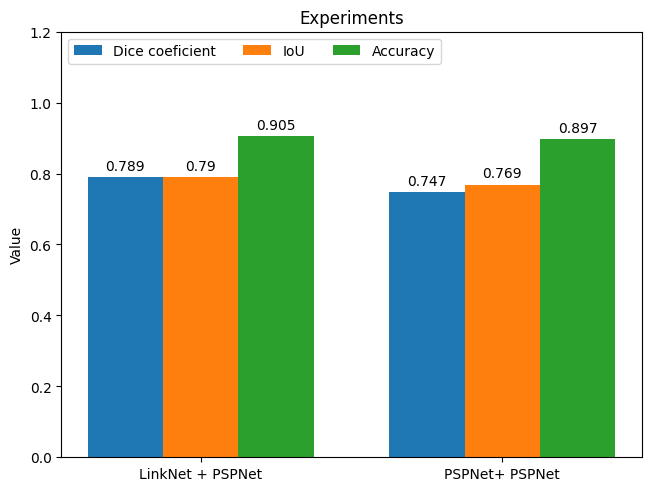

In [18]:
import matplotlib.pyplot as plt
import numpy as np

species = ("LinkNet + PSPNet", "PSPNet+ PSPNet")
measurements_values = {
    'Dice coeficient': (round(global_dice_test_linkpsp,3), round(global_dice_test_psppsp,3)),
    'IoU': (round(global_iou_test_linkpsp,3) ,round(global_iou_test_psppsp,3)),
    'Accuracy': (round(global_acc_test_linkpsp,3), round(global_acc_test_psppsp,3)),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in measurements_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Experiments')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()